In [212]:
# Libs
import pandas as pd
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import re

In [213]:
# General
SEED = 42
random.seed(SEED)

# Loading Data

## Keypoints

(files are just swapped out, names are the same, just less work)

In [214]:
df_kp = pd.read_feather("../Data/Cleaned/df_dta_qt_cleaned.feather")
df_kp = df_kp.rename(columns={"ID_qt": "ID_kp", "QUOTES": "KEY_POINT"})
print(df_kp.head())

   ID_kp  ID_dta                                          KEY_POINT
0      1      22  I had a little bit of pain in my duodenum as a...
1      2      25  It was big, big cramps in my abdomen. Vomiting...
2      3      25  So I had the symptoms of pain, I had the sympt...
3      4      26  It was big, big cramps in my abdomen. Vomiting...
4      5      26  So I had the symptoms of pain, I had the sympt...


## Questionnaire

In [215]:
df_kp_answers = pd.read_excel("../Data/Questionnaires_answers/Questionnaire_qt_answers.xlsx", engine='openpyxl')

Transpose the database.

In [216]:
df_kp_answers = df_kp_answers.T
df_kp_answers.columns = df_kp_answers.iloc[0].astype(str)
df_kp_answers = df_kp_answers[1:]
df_kp_answers.reset_index(inplace=True)

Rename the columns to more clear names.

In [217]:
df_kp_answers.rename(columns={
    'index': 'Question',
    '2025-04-28 10:43:40.704000': 'answer1',
    '2025-04-28 11:54:08.550000': 'answer2',
    '2025-04-30 11:52:19.786000': 'answer3'
}, inplace=True)

In [218]:
print(df_kp_answers.iloc[2])

Tijdstempel
Question    3/20\n\nQuote 1 (Q1):\nHe's supposed to have a...
answer1                                                     2
answer2                                                     5
answer3                                                     3
Name: 2, dtype: object


In [219]:
print(df_kp_answers.at[2, 'Question'])

3/20

Quote 1 (Q1):
He's supposed to have a liaison nurse, who manages all the issues. What I don't know, is whether it's because of lack of resources or... Anyway, she's not very accessible because I don't think she has many hours to handle this. There are a lot of Crohn's patients and so she's a bit overloaded. So there's not really any follow-up of the file, and when you send questions you have to send reminders to get answers, so it's a bit tiring.”
Quote 2 (Q2):
[...] so he gave me [name antispasmodic] and he said, 'It's going to pass, don’t worry!' and then it went on like that for months and then at some point I had [...] canker sores in my mouth. I didn't know how to eat anymore. My cheek had swollen, I looked like a hamster.” 


# Quick Analysis

## Keypoints

In [220]:
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID_kp      196 non-null    int32 
 1   ID_dta     196 non-null    int32 
 2   KEY_POINT  196 non-null    object
dtypes: int32(2), object(1)
memory usage: 3.2+ KB


## Questionnaire

In [221]:
df_kp_answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  20 non-null     object
 1   answer1   20 non-null     object
 2   answer2   20 non-null     object
 3   answer3   20 non-null     object
dtypes: object(4)
memory usage: 768.0+ bytes


# Data Preprocessing

## Keypoints

Remove empty value.

In [222]:
df_kp = df_kp[df_kp['KEY_POINT'] != '']

Normalize all white spaces, just to be sure.

In [223]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', str(text))
    return text.strip().lower()

df_kp['KEY_POINT_normalized'] = df_kp['KEY_POINT'].apply(clean_text)

Normalize values.

In [224]:
df_kp['KEY_POINT_normalized'] = df_kp['KEY_POINT'].str.strip().str.replace('\n', ' ').str.replace('\r', ' ').str.lower()

Setting ID's for distinct keypoints to give the same score to the same keypoint.

In [225]:
df_kp['ID_kp_distinct'] = pd.factorize(df_kp['KEY_POINT'])[0]
print(df_kp.head(10))

   ID_kp  ID_dta                                          KEY_POINT  \
0      1      22  I had a little bit of pain in my duodenum as a...   
1      2      25  It was big, big cramps in my abdomen. Vomiting...   
2      3      25  So I had the symptoms of pain, I had the sympt...   
3      4      26  It was big, big cramps in my abdomen. Vomiting...   
4      5      26  So I had the symptoms of pain, I had the sympt...   
5      6      28  [...] so he gave me [name antispasmodic] and h...   
6      7      31  I used to take long naps, spend a lot of time ...   
7      8      33  I don't just say because I also have a lot of ...   
8      9      34  Been home for a week, and I found the fatigue ...   
9     10      36  It was big, big cramps in my abdomen. Vomiting...   

                                KEY_POINT_normalized  ID_kp_distinct  
0  i had a little bit of pain in my duodenum as a...               0  
1  it was big, big cramps in my abdomen. vomiting...               1  
2  so

## Questionnaire

Change datatypes of the answers, and normalize.

In [226]:
df_kp_answers['answer1'] = df_kp_answers['answer1'].astype('Int64') - 3
df_kp_answers['answer2'] = df_kp_answers['answer2'].astype('Int64') - 3
df_kp_answers['answer3'] = df_kp_answers['answer3'].astype('Int64') - 3

Import ID's from the keypoints.

In [227]:
df_kp_answers['var1_label'] = None
df_kp_answers['var2_label'] = None

In [228]:
def kp_to_dist_idx(kp):
    kp_clean = kp.strip().replace('\n', ' ').replace('\r', ' ').lower()
    # (Some problem with double spaces)
    matching_rows = df_kp[df_kp['KEY_POINT_normalized'].str.replace(" ", "", regex=False) == kp_clean.replace(" ", "")]

    if not matching_rows.empty:
        return matching_rows['ID_kp_distinct'].iloc[0]
    else:
        print(f"Keypoint not found:\n{kp}")
        return None


for index, row in df_kp_answers.iterrows():
    parts = row['Question'].split("Quote 2 (Q2):")
    kp1 = parts[0].split("Quote 1 (Q1):")[1].strip()
    kp2 = parts[1].strip()

    idx1 = kp_to_dist_idx(kp1)
    idx2 = kp_to_dist_idx(kp2)
    
    df_kp_answers.at[index, 'var1_label'] = idx1
    df_kp_answers.at[index, 'var2_label'] = idx2

In [229]:
print(df_kp_answers.head())

Tijdstempel                                           Question  answer1  \
0            1/20\n\nQuote 1 (Q1):\nYes, about the treatmen...       -1   
1            2/20\n\nQuote 1 (Q1):\nI've learned, and that'...       -1   
2            3/20\n\nQuote 1 (Q1):\nHe's supposed to have a...       -1   
3            4/20\n\nQuote 1 (Q1):\nNow we are in the phase...        1   
4            5/20\n\nQuote 1 (Q1):\nThey explained to me [....       -1   

Tijdstempel  answer2  answer3 var1_label var2_label  
0                 -2        0        128         31  
1                  2        0         31        121  
2                  2        0         48          3  
3                 -1       -1        109        116  
4                 -2        0        127         25  


In [230]:
# Test if this is correct
print((df_kp[df_kp['ID_kp_distinct'] == 73])['KEY_POINT'].head(1))
print((df_kp[df_kp['ID_kp_distinct'] == 5])['KEY_POINT'].head(1))
print((df_kp[df_kp['ID_kp_distinct'] == 69])['KEY_POINT'].head(1))

83    “I say it, the people at the hospital themselv...
Name: KEY_POINT, dtype: object
7    I don't just say because I also have a lot of ...
Name: KEY_POINT, dtype: object
79    “ Fortunately, I have a good partner who suppo...
Name: KEY_POINT, dtype: object


Get mean of the answers.

In [231]:
df_kp_answers['answer_mean'] = df_kp_answers[['answer1', 'answer2', 'answer3']].mean(axis=1)

Set 5-class to 3-class system. Why? -> less noise. (-1, 0, 1)

In [232]:
df_kp_answers['answer1_base3'] = None
df_kp_answers['answer2_base3'] = None
df_kp_answers['answer3_base3'] = None

def convert_5_to_3(value):
    if value in [-2, -1]:
        return -1
    elif value == 0:
        return 0
    elif value in [1, 2]:
        return 1
    else:
        print(f"Bad value!: {value}")
        return None

for index, row in df_kp_answers.iterrows():
    df_kp_answers.at[index, 'answer1_base3'] = convert_5_to_3(df_kp_answers.at[index, 'answer1'])
    df_kp_answers.at[index, 'answer2_base3'] = convert_5_to_3(df_kp_answers.at[index, 'answer2'])
    df_kp_answers.at[index, 'answer3_base3'] = convert_5_to_3(df_kp_answers.at[index, 'answer3'])
    df_kp_answers.at[index, 'answer_base3_mean'] = df_kp_answers[['answer1_base3', 'answer2_base3', 'answer3_base3']].iloc[index].mean()

In [233]:
print(df_kp_answers.head())

Tijdstempel                                           Question  answer1  \
0            1/20\n\nQuote 1 (Q1):\nYes, about the treatmen...       -1   
1            2/20\n\nQuote 1 (Q1):\nI've learned, and that'...       -1   
2            3/20\n\nQuote 1 (Q1):\nHe's supposed to have a...       -1   
3            4/20\n\nQuote 1 (Q1):\nNow we are in the phase...        1   
4            5/20\n\nQuote 1 (Q1):\nThey explained to me [....       -1   

Tijdstempel  answer2  answer3 var1_label var2_label  answer_mean  \
0                 -2        0        128         31         -1.0   
1                  2        0         31        121     0.333333   
2                  2        0         48          3     0.333333   
3                 -1       -1        109        116    -0.333333   
4                 -2        0        127         25         -1.0   

Tijdstempel answer1_base3 answer2_base3 answer3_base3  answer_base3_mean  
0                      -1            -1             0          -0

# Analysing uncertainty in answers.

Get answer ranges.

In [234]:
df_kp_answers['answer_range'] = df_kp_answers[['answer1', 'answer2', 'answer3']].max(axis=1) - df_kp_answers[['answer1', 'answer2', 'answer3']].min(axis=1)
df_kp_answers['answer_base3_range'] = df_kp_answers[['answer1_base3', 'answer2_base3', 'answer3_base3']].max(axis=1) - df_kp_answers[['answer1_base3', 'answer2_base3', 'answer3_base3']].min(axis=1)

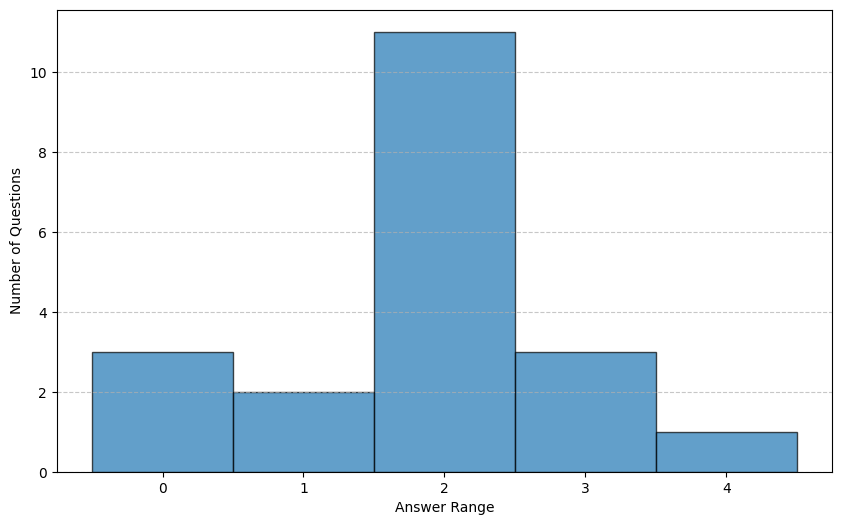

In [235]:
plt.figure(figsize=(10, 6))
plt.hist(df_kp_answers['answer_range'].dropna(), bins=np.arange(-0.5, df_kp_answers['answer_range'].max() + 1.5, 1), edgecolor='black', alpha=0.7)
plt.xlabel("Answer Range")
plt.ylabel("Number of Questions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, df_kp_answers['answer_range'].max() + 1, 1))  # integers only
plt.show()

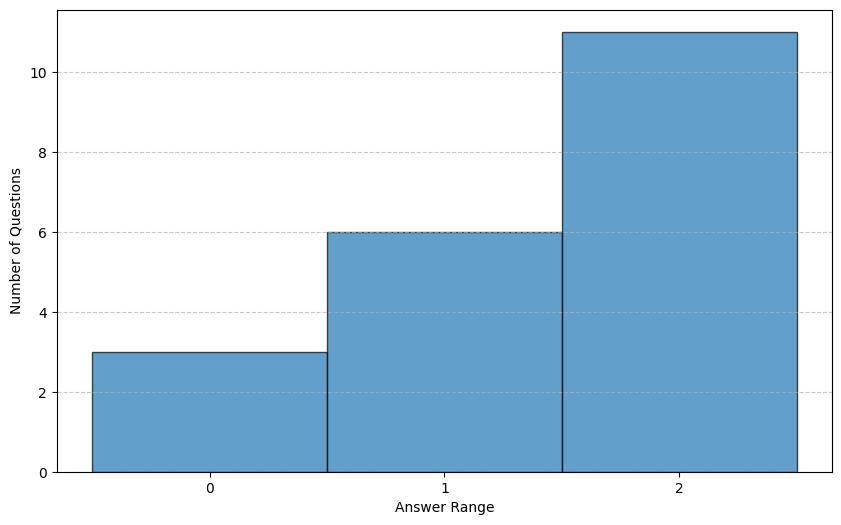

In [236]:
plt.figure(figsize=(10, 6))
plt.hist(df_kp_answers['answer_base3_range'].dropna(), bins=np.arange(-0.5, df_kp_answers['answer_base3_range'].max() + 1.5, 1), edgecolor='black', alpha=0.7)
plt.xlabel("Answer Range")
plt.ylabel("Number of Questions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, df_kp_answers['answer_base3_range'].max() + 1, 1))  # integers only

plt.savefig("figs/answer_range_histogram_qt_3.png", dpi=300, bbox_inches='tight')
plt.show()

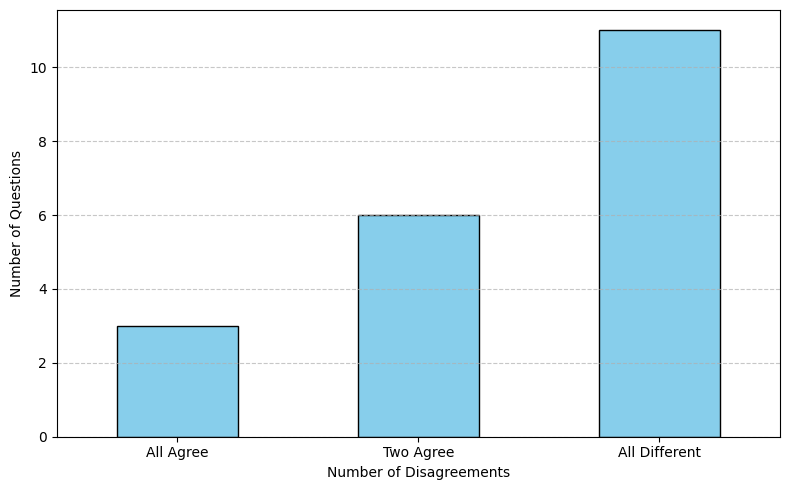

In [237]:
def count_disagreements(row):
    a = [row['answer1'], row['answer2'], row['answer3']]
    return len(set(a)) - 1

df_kp_answers['pairwise_disagreement'] = df_kp_answers.apply(count_disagreements, axis=1)
disagreement_counts = df_kp_answers['pairwise_disagreement'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
disagreement_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Number of Disagreements")
plt.ylabel("Number of Questions")
plt.xticks([0, 1, 2], ['All Agree', 'Two Agree', 'All Different'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

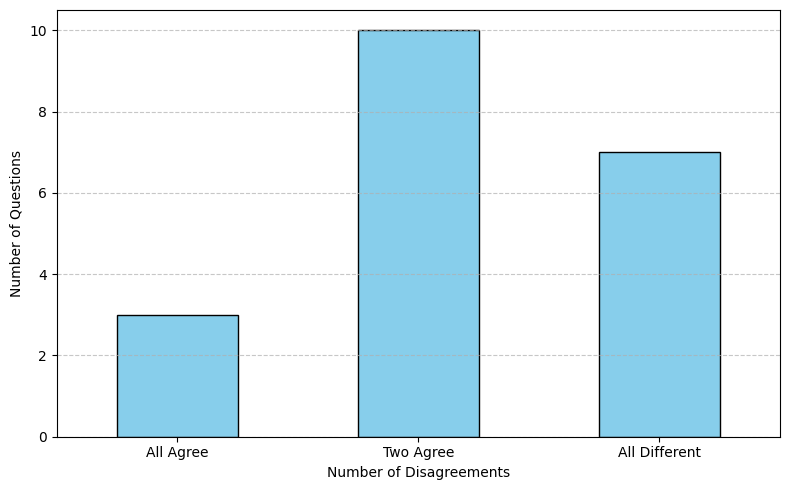

In [238]:
def count_disagreements(row):
    a = [row['answer1_base3'], row['answer2_base3'], row['answer3_base3']]
    return len(set(a)) - 1

df_kp_answers['pairwise_disagreement'] = df_kp_answers.apply(count_disagreements, axis=1)
disagreement_counts = df_kp_answers['pairwise_disagreement'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
disagreement_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Number of Disagreements")
plt.ylabel("Number of Questions")
plt.xticks([0, 1, 2], ['All Agree', 'Two Agree', 'All Different'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("figs/disagreements_qt_3.png", dpi=300, bbox_inches='tight')
plt.show()

Trend among experts answers

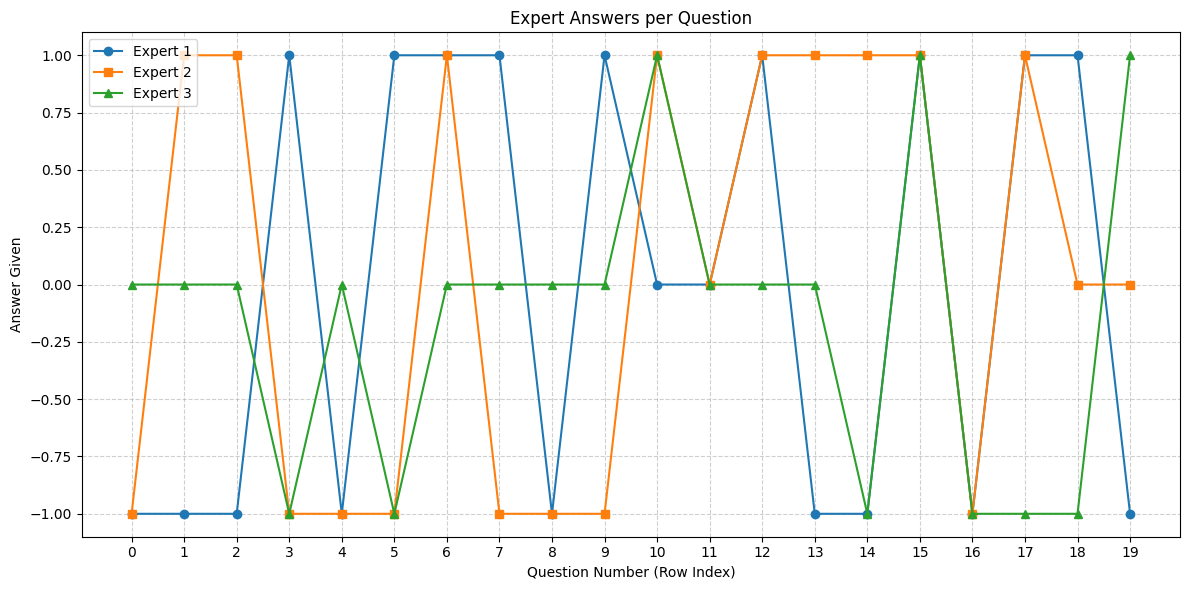

In [239]:
# Create figure
plt.figure(figsize=(12, 6))

# Plot each expert's answers
plt.plot(df_kp_answers.index, df_kp_answers['answer1_base3'], label='Expert 1', marker='o')
plt.plot(df_kp_answers.index, df_kp_answers['answer2_base3'], label='Expert 2', marker='s')
plt.plot(df_kp_answers.index, df_kp_answers['answer3_base3'], label='Expert 3', marker='^')

# Add plot details
plt.title("Expert Answers per Question")
plt.xlabel("Question Number (Row Index)")
plt.ylabel("Answer Given")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_kp_answers.index)  # Ensure all questions are shown if desired
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

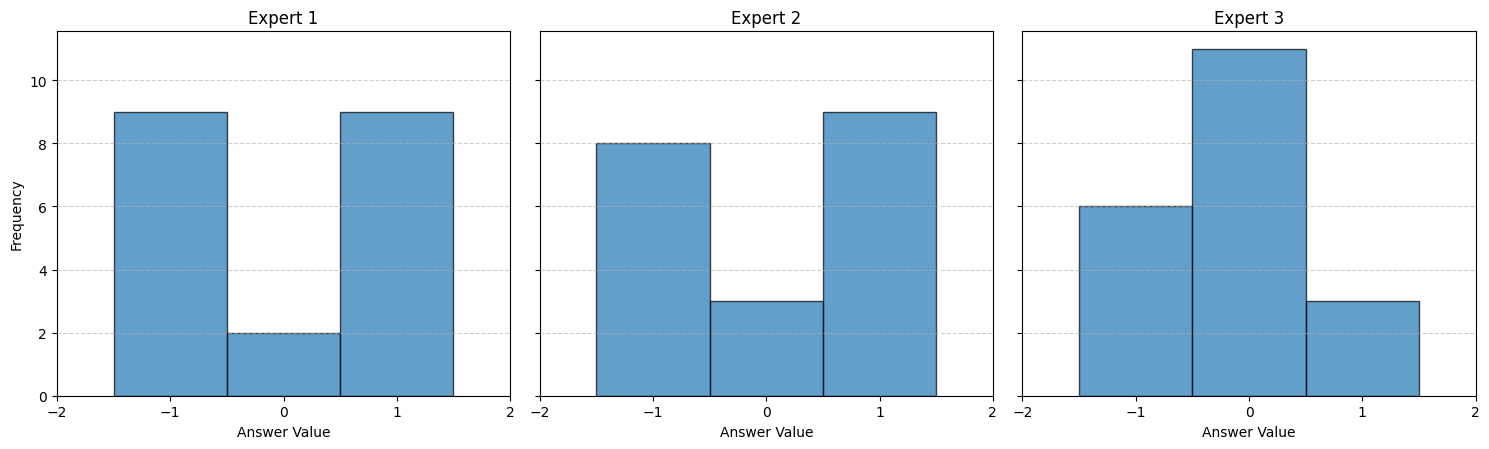

In [240]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

bins = [-1.5, -0.5, 0.5, 1.5]  # bins to capture values from -2 to 2

experts = ['answer1_base3', 'answer2_base3', 'answer3_base3']
titles = ['Expert 1', 'Expert 2', 'Expert 3']

for i in range(3):
    axes[i].hist(df_kp_answers[experts[i]].dropna(), bins=bins, edgecolor='black', alpha=0.7)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Answer Value")
    axes[i].set_xticks([-2, -1, 0, 1, 2])
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

axes[0].set_ylabel("Frequency")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("figs/answers_distribution_qt_3.png", dpi=300, bbox_inches='tight')
plt.show()

In [241]:
answers = df_kp_answers[['answer1_base3', 'answer2_base3', 'answer3_base3']]

# Initialize a dictionary to store agreement counts
agreements = {
    ('Expert 1', 'Expert 2'): (answers['answer1_base3'] == answers['answer2_base3']).sum(),
    ('Expert 1', 'Expert 3'): (answers['answer1_base3'] == answers['answer3_base3']).sum(),
    ('Expert 2', 'Expert 3'): (answers['answer2_base3'] == answers['answer3_base3']).sum()
}

# Print results
for (e1, e2), count in agreements.items():
    print(f"{e1} agrees with {e2} on {count} questions")

Expert 1 agrees with Expert 2 on 9 questions
Expert 1 agrees with Expert 3 on 4 questions
Expert 2 agrees with Expert 3 on 6 questions


# Pairwise comparisons to score

## Calculate net scores

### Create Graph

Find keypoints with the same urgency. These cannot be implemented as different nodes in a graph. Otherwise we would get either a cyclical graph, or get nodes that cannot accurately calculate their maximum forward, and backward steps.

In [242]:
equivalent_keypoints = [] # First value in each array is the key of the node.

# Returns -1 if no equivalency already present, otherwise returns the index in the array.
def find_equivalence_index(label):
    for idx, group in enumerate(equivalent_keypoints):
        if label in group:
            return idx
    return -1

# Iterate trough all answers to identify equivalent nodes.
for index, row in df_kp_answers.iterrows():
    label1 = df_kp_answers.at[index, 'var1_label']
    label2 = df_kp_answers.at[index, 'var2_label']
    answer = df_kp_answers.at[index, 'answer_base3_mean']

    if answer == 0:
        idx1 = find_equivalence_index(label1)
        idx2 = find_equivalence_index(label2)

        if idx1 > -1 and idx2 > -1:
            if idx1 != idx2:
                # Merge two groups
                equivalent_keypoints[idx1].extend(equivalent_keypoints[idx2])
                equivalent_keypoints.pop(idx2)
        elif idx1 > -1:
            equivalent_keypoints[idx1].append(label2)
        elif idx2 > -1:
            equivalent_keypoints[idx2].append(label1)
        else:
            equivalent_keypoints.append([label1, label2])

print(str(equivalent_keypoints))

[[np.int64(31), np.int64(121), np.int64(130), np.int64(48), np.int64(3)], [np.int64(1), np.int64(128)], [np.int64(10), np.int64(38), np.int64(109)], [np.int64(78), np.int64(30)]]


Create graph

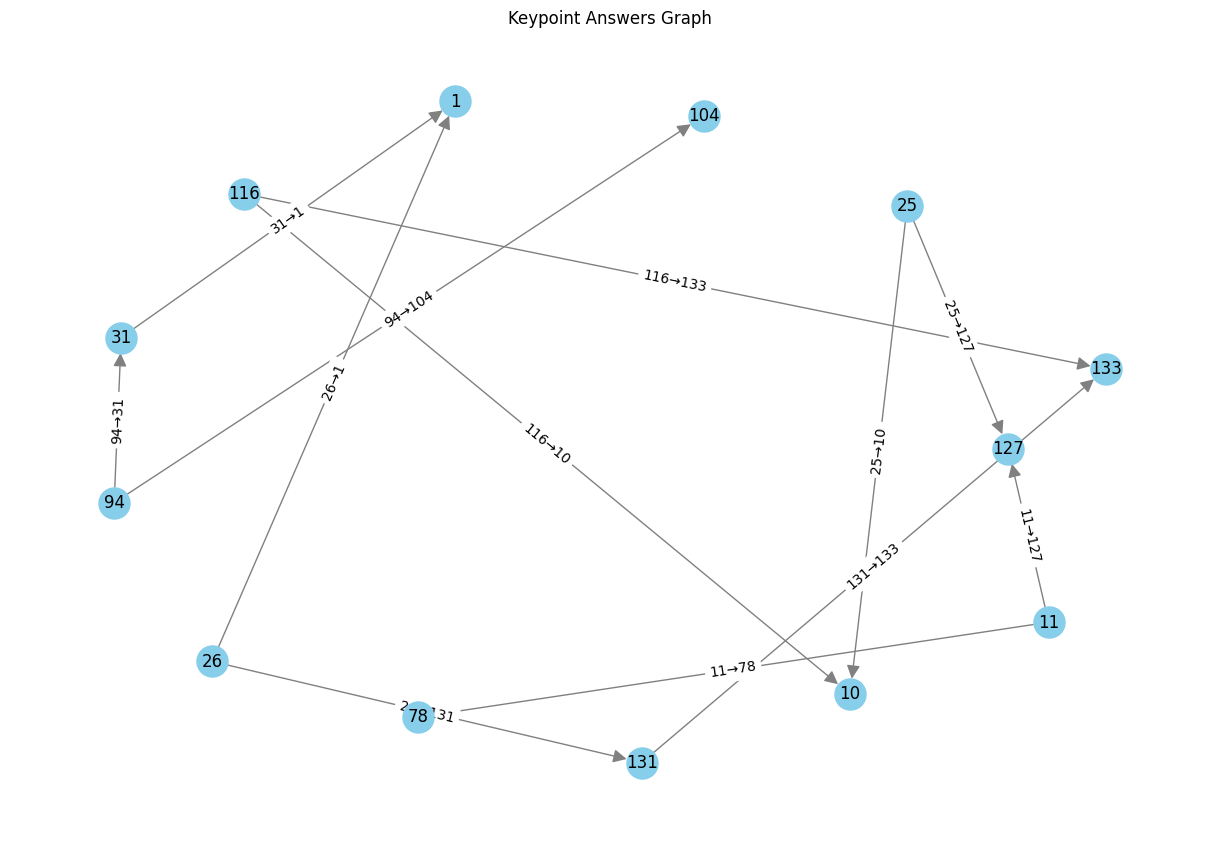

In [243]:
G = nx.DiGraph()

for index, row in df_kp_answers.iterrows():
    label1 = df_kp_answers.at[index, 'var1_label']
    label2 = df_kp_answers.at[index, 'var2_label']
    answer = df_kp_answers.at[index, 'answer_base3_mean']

    idx1 = find_equivalence_index(label1)
    idx2 = find_equivalence_index(label2)

    if idx1 > -1:
        label1 = equivalent_keypoints[idx1][0]
    if idx2 > -1:
        label2 = equivalent_keypoints[idx2][0]

    if answer < 0:
        G.add_edges_from([(str(label2), str(label1))])
    elif answer > 0:
        G.add_edges_from([(str(label1), str(label2))])
    # Not necessary to add edges with equivalent keypoints.
        

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=20)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{u}→{v}" for u, v in G.edges()})
plt.title("Keypoint Answers Graph")
plt.show()

In [244]:
len(G.nodes())

13

It is essential that there are no cycles in the graph!

In [245]:
cycles = list(nx.simple_cycles(G))
print("Cycles found:")
for cycle in cycles:
    print(cycle)
if not cycles: print("None!")

Cycles found:
None!


### Calculate net-scores & transitive closure

In [246]:
def calculate_net_scores(G):
    TC = nx.transitive_closure(G)

    data = []
    for node in TC.nodes():
        out = len(list(TC.successors(node)))
        inc = len(list(TC.predecessors(node)))
        data.append((node, inc - out, out, inc))

    df_scores = pd.DataFrame(data, columns=['item','net_score', 'out', 'inc']).set_index('item')
    df_scores.index = df_scores.index.astype('int64')
    return df_scores


df_scores = calculate_net_scores(G)
print(df_scores)

      net_score  out  inc
item                     
31            0    1    1
1             3    0    3
116          -2    2    0
10            2    0    2
25           -2    2    0
127           2    0    2
131           0    1    1
133           3    0    3
94           -3    3    0
104           1    0    1
26           -3    3    0
11           -2    2    0
78            1    0    1


# Export Labeled Data

## Label Data

In [247]:
df_scores['label'] = assign_predicted_classes_2(df_scores['net_score'], cutoff=0)
df_scores

,net_score,out,inc,label
item,,,,
31,0,1,1,0
1,3,0,3,1
116,-2,2,0,0
10,2,0,2,1
25,-2,2,0,0
127,2,0,2,1
131,0,1,1,0
133,3,0,3,1
94,-3,3,0,0


In [248]:
print(equivalent_keypoints)

[[np.int64(31), np.int64(121), np.int64(130), np.int64(48), np.int64(3)], [np.int64(1), np.int64(128)], [np.int64(10), np.int64(38), np.int64(109)], [np.int64(78), np.int64(30)]]


In [249]:
df_new_rows = []

for group in equivalent_keypoints:
    original_idx = group[0]
    equivalents = group[1:]

    if original_idx in df_scores.index:
        original_row = df_scores.loc[original_idx]

        for eq in equivalents:
            new_row = original_row.copy()
            new_row.name = eq  # Assign new index
            df_new_rows.append(new_row)

df_scores_extended = pd.concat([df_scores, pd.DataFrame(df_new_rows)])
df_scores_extended = df_scores_extended.sort_index()

df_scores = df_scores_extended
df_scores

,net_score,out,inc,label
1,3,0,3,1
3,0,1,1,0
10,2,0,2,1
11,-2,2,0,0
25,-2,2,0,0
26,-3,3,0,0
30,1,0,1,1
31,0,1,1,0
38,2,0,2,1
48,0,1,1,0


## Create Labeled <-> Unlabeled Data

In [250]:
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185 entries, 0 to 195
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_kp                 185 non-null    int32 
 1   ID_dta                185 non-null    int32 
 2   KEY_POINT             185 non-null    object
 3   KEY_POINT_normalized  185 non-null    object
 4   ID_kp_distinct        185 non-null    int64 
dtypes: int32(2), int64(1), object(2)
memory usage: 7.2+ KB


In [251]:
df_scores.index

Index([  1,   3,  10,  11,  25,  26,  30,  31,  38,  48,  78,  94, 104, 109,
       116, 121, 127, 128, 130, 131, 133],
      dtype='int64')

In [252]:
df_kp_tmp = df_kp.drop_duplicates(subset='ID_kp_distinct', keep='first')

In [253]:
df_kp_labeled = df_kp_tmp[df_kp_tmp['ID_kp_distinct'].isin(df_scores.index)].copy()
df_kp_unlabeled = df_kp_tmp[~df_kp_tmp['ID_kp_distinct'].isin(df_scores.index)]

df_kp_labeled.loc[:, 'label'] = df_kp_labeled['ID_kp_distinct'].map(df_scores['label'])
print(df_kp_labeled)

     ID_kp  ID_dta                                          KEY_POINT  \
1        2      25  It was big, big cramps in my abdomen. Vomiting...   
5        6      28  [...] so he gave me [name antispasmodic] and h...   
16      17      50  I went to a psychologist once, back then becau...   
17      18      50   I always have to have a toilet within reach. ...   
31      32      66  “ I also had surgery [...] then started taking...   
32      33      66  The [name interleukin inhibitor] works very we...   
36      37      66  He doesn't have any treatment... Finally... so...   
37      38      66  I've learned, and that's it, just to know myse...   
44      45      68  What I often notice with doctors is that they ...   
54      55      69  He's supposed to have a liaison nurse, who man...   
89      90     101  Having trouble finding words, not being able t...   
107    108     150  Because I am sick, but if I die, my wife will ...   
158    159     157  And on a mental health level, y

## Export

In [254]:
df_kp_labeled = df_kp_labeled.reset_index(drop=True)
df_kp_unlabeled = df_kp_unlabeled.reset_index(drop=True)

df_kp_labeled.to_feather('../Data/TrainingData/df_qt_labeled.feather')
df_kp_unlabeled.to_feather('../Data/TrainingData/df_qt_unlabeled.feather')